# Financial market data analysis with pandas
Pandas is a great tool for time series analysis of financial market data. Because pandas ```DataFrame```s and ```Series``` [work well with a date/time based index](https://www.wrighters.io/indexing-time-series-data-in-pandas/), it can be used effectively to analyze historical data. When I say financial market data, I'm talking specifically about data like historical price information on a publicly traded financial instrument, although any sort of historical financial information can be analyzed. 

Time series data will be available at different frequencies. Some financial instruments are liquid enough that we can view the price at almost any point in time, and it changes almost constantly. The idea of an instrument being liquid means that there are willing buyers and sellers that you can easily trade with in normal trading times, and they are willing to buy and sell enough of the instrument for your trading needs. For instruments that trade on an exchange, the prices that buyers and sellers are willing to pay or offer are available during the normal trading hours of that instrument. 

Since a lot of financial data is available, much of it free, it makes a great playground to learn more about analyzing and working with time series data. There are many things we that can learn about both public markets and pandas by using this data to understand some of the data available to us. In this article I'm going to walk you through how to do some simple analysis and discover a few things about the stock market.

For this article, we will look at one common effect seen in financial markets: seasonality. Seasonality is a characteristic of time series data where a regular effect can be seen based on time. It may be the time of year, the time of month, time of day, or even minute of the hour. I'll show you how to download some data (in this case daily stock data) and then use pandas and matplotlib to verify that the data looks reasonable. Then, we'll investigate if there is monthly seasonality in the data. Along the way, I'll walk through the code and offer some pointers to go learn more if you're intersted.

In future articles, I'll look at some other interesting effects seen in daily (one data point per day) and intraday (many data points per day) data.

## Getting data
One of the biggest frustrations with dealing with market data is getting ahold of it in the first place. Financial data can be valuable, and so those who own it will typically charge for it. Data gets more valuable in mulitiple dimensions, such as breadth, time, and quality. 

### Breadth of data
In the breadth dimension, we have information about a financial instrument. Consider one such financial instrument, a company's publicly traded common stock. We could access the price of that stock, but which price? For daily stock price data, this price is usually the closing price of the stock at 16:00 America/New_York. But we also might want to know the price of the stock at the opening of the stock market at 09:30 America/New_York. And maybe we want to know the highest price for the day and the lowest price for the day. Finally, we might want to know how many shares traded during the course of the entire day (known as the volume).  In this example of daily data, the breadth dimension contains 5 pieces of information: last trade price (or the close), first trade price (or the open), the highest trade price (high) and the lowest trade price (low), along with the total volume for the day.

The more detailed the data, the more costly it can be. Instead of just trade prices, we could get the bid and ask prices. These are the prices that someone is willing to pay for (bid) or sell (ask) a given instrument. Along with prices, we might want to know the quantity of shares that are asked for by buyers (bid size) or for offer by sellers (ask size). This data may be available at extremely granular levels (often called tick data) or it may be aggregated into summary data (often called bars). 

### When and how often do we get updates, and for how much of history?
Let's consider the time dimension. We are dealing with daily data, but how many days of data can we get? The more historical data you can get, the more valuable it is for analyzing past trends and effects, so we want to go back in time as far as possible to look for information in the markets.

Now we also could change the time dimension by making it smaller. Instead of looking at data every day, we could look at it every hour, or ever 15 minutes, or every minute. We may even want to look at ever single update of data. It turns out that daily data is pretty easy to get, but data at a more granular level is harder to get for free. 

In the time dimension we also think about the speed at which current data is given to us. For this article, we are only looking at historical data, but for use cases where software or a person needs to react to the data, the sooner it arrives, the more valuable it is.

### How good is the data?
Quality is also very important for financial data. If data is missing or inaccurate, it may yield incorrect results. Often, data can be analyzed to ensure it's reasonable, but detecting all errors can be extremely difficult.

## A good piece of data to look at
For now, let's just get started by grabbing some historical data for an exchange traded fund (ETF) with the ticker SPY. SPY is sort of special. SPY isn't a stock of a company, but a special instrument that mirrors roughly the value of the entire S&P 500 Index. This index has stocks of around 500 of the largest US publicly traded companies in it, and it the index is updated regularly. Companies are included in the index if they are profitable (mostly) and roughly in the top 500 companies in market capitalization. The price of the ETF will move (roughly) up and down at the same rate as the combined stocks times their index weight during the course of a regular trading day. The main reason we'll use it for now is because it is a good way to get (for free) a rough look at how the US stock market is doing for any day of the year. It also is highly liquid, so accurate prices are almost always available and many market participants are willing to buy and sell it at any time.

## One data source
There are multiple ways to get historical price data, and I've [written](https://www.wrighters.io/3-ways-to-get-historical-market-data-from-iex-cloud/) about a [few](https://www.wrighters.io/how-to-get-historical-market-data-from-interactive-brokers-using-python/) of them before. For this article, I'll use [Alpha Vantage](https://www.alphavantage.co), a provider of financial market data. You can get a free API key to follow along on your own.

Note that I will not provide you with this data here (or anywhere else) since I don't own it. In general, when you want to work with financial data you will have to find a company who is authorized to provide this information to you. The more historically complete, accurate, and precise the information is, the more you will expect to have to pay to be given the information to use. For this article, the data is fairly common, so you can access it for free.

## Downloading historical data
I'll get as much historical data for the SPY ETF as Alpha Vantage will allow.  You can read [the Alpha Vantage documentation](https://www.alphavantage.co/documentation/) to see other options, but for now, we'll just query for their daily time series data.

In [1]:
import io

import pandas as pd
import requests

import matplotlib.pyplot as plt

In [2]:
API_KEY='demo' # replace with your API_KEY from Alpha Vantage

From Alpha Vantage, we can get data in CSV (Comma Separated Values) or JSON (JavaScript Object Notation) format. Let's look at CSV first. You fetch the results by making an HTTP call to their service endpoint. If we use the ```requests``` library as they suggest, the result is stored in the ```content``` variable as bytes. We can turn this into a string and inspect the first few rows to see what the data looks like.

In [3]:
# full history of daily data
function = "TIME_SERIES_DAILY_ADJUSTED" # daily data
outputsize = "full"                     # all of it
datatype = "csv"                        # CSV - comma separated values
url = f"https://www.alphavantage.co/query?function={function}&symbol=SPY&outputsize=full&apikey={API_KEY}&datatype={datatype}"
res = requests.get(url)

# the CSV file content is all available in the reponse
res.content.decode().split("\r\n")[0:2]

['timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient',
 '2021-11-29,464.07,466.56,461.73,464.6,464.6,82666545,0.0000,1.0']

Since the service returns the most recent data first, we'll parse the csv using pandas and ensure we sort the index so earliest data is first in our ```DataFrame```.  We need to give the ```read_csv``` some hints to tell it to parse the first column as datetime data, and then to use that column as the index of the ```DataFrame```.

Because the most recent row is the first element, we will also sort the ```DataFrame``` by its index, since we want data in chronological order.

Note I also use ```io.StringIO``` here because I already have the data all in memory. As you'll see in a minute, we can do this all much faster exclusively in pandas if we want to.

Do you have questions about pandas indexes? You can learn all about them starting [here](https://www.wrighters.io/indexing-and-selecting-in-pandas-part-1/).

In [4]:
spy_daily = pd.read_csv(io.StringIO(res.content.decode()),
                        parse_dates=['timestamp'],
                        index_col='timestamp').sort_index()

In [5]:
spy_daily.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
1999-11-01,136.500000,137.000000,135.562500,135.562500,90.318326,4006500,0.0,1.0
1999-11-02,135.968704,137.250000,134.593704,134.593704,89.672867,6516900,0.0,1.0
1999-11-03,136.000000,136.375000,135.125000,135.500000,90.276685,7222300,0.0,1.0
1999-11-04,136.750000,137.359299,135.765594,136.531204,90.963724,7907500,0.0,1.0
1999-11-05,138.625000,139.109299,136.781204,137.875000,91.859026,7431500,0.0,1.0


We can see that Alpha Vantage gives us data going all the way back to 1999, not bad! Having more than 20 years worth of data is helpful.

As I said earlier, we can do this all in one step in pandas (i.e, there's no need to use the ```requests```  library or ```StringIO```) by just passing the url into the ```read_csv``` call above, like this:

In [6]:
spy_daily = pd.read_csv(url, parse_dates=['timestamp'], index_col='timestamp').sort_index()

In [7]:
spy_daily.tail()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2021-11-22,470.89,473.540,467.35,467.57,467.57,72761954,0.0,1.0
2021-11-23,467.22,469.095,464.45,468.19,468.19,73206538,0.0,1.0
2021-11-24,466.06,469.570,465.19,469.44,469.44,61858813,0.0,1.0
2021-11-26,462.34,463.900,457.77,458.97,458.97,112669636,0.0,1.0
2021-11-29,464.07,466.560,461.73,464.60,464.60,82666545,0.0,1.0


In [8]:
spy_daily.dtypes

open                 float64
high                 float64
low                  float64
close                float64
adjusted_close       float64
volume                 int64
dividend_amount      float64
split_coefficient    float64
dtype: object

Pandas took care of noticing that the first argument was a url, fetched the results, and then turned the data into a ```DataFrame```. It even converted the data to valid types.

### What about JSON?
Since the data is also available in JSON format, let's use this opportunity to look at how you could read JSON data into a ```DataFrame``` as well.

In [9]:
datatype = "json"   # everything else the same, but let's get JSON instead
url = f"https://www.alphavantage.co/query?function={function}&symbol=SPY&outputsize=full&apikey={API_KEY}&datatype={datatype}"

res = requests.get(url)

The returned data is a bit different than the csv format. It's a JSON object with two members. The first is some metadata that we didn't get in the csv format above. Note that the data timestamps are ```US/Eastern```, where the US based stock exchanges reside.

In [10]:
res.json().keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [11]:
res.json()['Meta Data']

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'SPY',
 '3. Last Refreshed': '2021-11-29',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [12]:
res.json()['Time Series (Daily)']['2021-11-22']

{'1. open': '470.89',
 '2. high': '473.54',
 '3. low': '467.35',
 '4. close': '467.57',
 '5. adjusted close': '467.57',
 '6. volume': '72761954',
 '7. dividend amount': '0.0000',
 '8. split coefficient': '1.0'}

Since each element in the time series is a single day, the values are oriented by the time series index of the DataFrame. We can use the pandas ```DataFrame.from_dict``` method to create a valid ```DataFrame``` from these values. You need to make sure you orient the data as ```index```. The default option is ```columns```, which assumes that each object is an entire column of data. What we are getting instead is one object for each row, and the key is the index, in our case the date.

In [13]:
spy_daily = pd.DataFrame.from_dict(res.json()['Time Series (Daily)'], orient='index')

In [14]:
spy_daily.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2021-11-29,464.07,466.56,461.73,464.6,464.6,82666545,0.0000,1.0
2021-11-26,462.34,463.9,457.77,458.97,458.97,112669636,0.0000,1.0
2021-11-24,466.06,469.57,465.19,469.44,469.44,61858813,0.0000,1.0
2021-11-23,467.22,469.095,464.45,468.19,468.19,73206538,0.0000,1.0
2021-11-22,470.89,473.54,467.35,467.57,467.57,72761954,0.0000,1.0


In [15]:
spy_daily.index

Index(['2021-11-29', '2021-11-26', '2021-11-24', '2021-11-23', '2021-11-22',
       '2021-11-19', '2021-11-18', '2021-11-17', '2021-11-16', '2021-11-15',
       ...
       '1999-11-12', '1999-11-11', '1999-11-10', '1999-11-09', '1999-11-08',
       '1999-11-05', '1999-11-04', '1999-11-03', '1999-11-02', '1999-11-01'],
      dtype='object', length=5556)

We aren't quite done though. First, the index hasn't been parsed as a date yet, notice that its ```dtype``` is object. We can fix this pretty easily though. We have [several options for converting types](https://www.wrighters.io/converting-types-in-pandas/) in pandas, I'll use ```to_datetime``` for this one.

In [16]:
spy_daily = spy_daily.set_index(pd.to_datetime(spy_daily.index)).sort_index()

The second thing we'll want to clean up is the column names. You can use the [rename method](https://www.wrighters.io/basic-pandas-renaming-a-dataframe-column/) to do this, we just supply a function that takes the old column name and returns a new one. If we split the old name on spaces, remove the first token, and join the remaining tokens with an underscore, we can create the same columns we had with the csv format. 

In [17]:
def convert_name(name):
    tokens = name.split()
    return "_".join(tokens[1:])

convert_name("1. open") # see how this works?

'open'

In [18]:
# normally, I'd do this in one go like this: spy_daily.rename(columns=lambda c: "_".join(c.split()[1:]))
spy_daily = spy_daily.rename(columns=convert_name) 
spy_daily.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
1999-11-01,136.5,137.0,135.5625,135.5625,90.3183258389,4006500,0.0000,1.0
1999-11-02,135.968704,137.25,134.593704,134.593704,89.6728668602,6516900,0.0000,1.0
1999-11-03,136.0,136.375,135.125,135.5,90.2766853014,7222300,0.0000,1.0
1999-11-04,136.75,137.359299,135.765594,136.531204,90.9637235227,7907500,0.0000,1.0
1999-11-05,138.625,139.109299,136.781204,137.875,91.8590257264,7431500,0.0000,1.0


Finally, you see that the JSON data was in a string format. Take a closer look at the data. If you started working with the ```DataFrame``` you'd soon notice it wasn't behaving properly.

In [19]:
spy_daily.dtypes

open                 object
high                 object
low                  object
close                object
adjusted_close       object
volume               object
dividend_amount      object
split_coefficient    object
dtype: object

If we don't convert these values to numeric types, we'll have issues. In some cases, you'll get an answer (that will be wrong) or maybe just an error. For example:

In [20]:
spy_daily['high'].max()

'99.879997'

That is a string, and is definitely not the maximum price of SPY. We'll need to convert it to a numeric value.  Again, you can read more about type conversions in pandas in [this article](https://www.wrighters.io/converting-types-in-pandas/), but one simple way to do this is to use ```to_numeric``` on each column.

In [21]:
for c in spy_daily.columns:
    spy_daily[c] = pd.to_numeric(spy_daily[c])

spy_daily.dtypes

open                 float64
high                 float64
low                  float64
close                float64
adjusted_close       float64
volume                 int64
dividend_amount      float64
split_coefficient    float64
dtype: object

### When can we use the data?
That looks like a lot of extra work compared to just using the csv format, but I chose to do this both ways so you can see it's possible to deal with different data source formats with just a little bit of effort. Note that pandas also has a ```read_json``` method which can be used for ```DataFrame``` creation from JSON sources, but since this data has the actual data buried deeper in the object, it made more sense to use the method above. As is always the case with pandas, there's more than one way to do it! Maybe you can find an even better way to do it.

## Initial validation
Often one of the best ways to quickly validate price data is to just look at it. Using ```DataFrame.plot``` is a great way to do this quickly.

<AxesSubplot:>

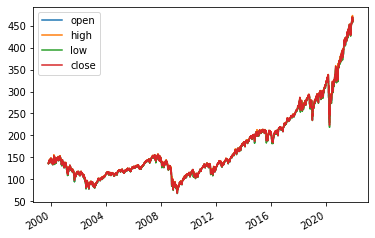

In [22]:
spy_daily[['open', 'high', 'low', 'close']].plot()

First of all, we can see our data goes back to 2020, that it is continuous, and looks reasonably like the price of SPY based on what we've seen before. I plotted all 4 prices (the open, high, low, and close) to make sure there weren't any 0's in the data or wildly inaccurate prices. There are also no obvious gaps in data, so that's a good sign.

If data were missing, you'd see a straight line between two dates (as long as the gap was large enough). If there were wild values, like 0 or infinity, you'd definitely notice that on the plot.

We could create entire books on data validation, so for now we'll move on to understanding the data a bit more.

## Bars, or candles
With the plot above, you can see it's hard to tell the difference between the four lines. Even just looking at a few days, it's not entirely clear to read when all four lines are displayed.

<AxesSubplot:>

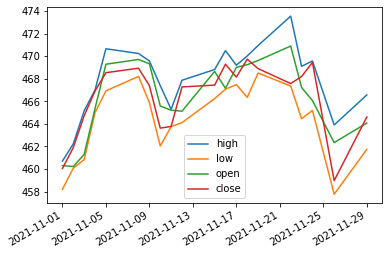

In [23]:
spy_daily[-20:][['high', 'low', 'open', 'close']].plot()

We can display the data in a more useful way, usually called a *bar*, or a *candle*. In my professional experience, I've always called rolled up time periods of price data a bar, but they are also often called candles because of how they look when plotted. We can do this easily using matplotlib bar charts.

Each bar will be colored green if the price went up during the day, it will be red if it went down. The "candlestick" part of the bar will be bounded by the open and close price, the "wick" part of the candle will be bounded by the high and low price. From this one plot, you can see quickly what happened each day - i.e. did the price move a lot during the day? Did it have a wide range but little move between the open and close? Did the price move up, or down? 

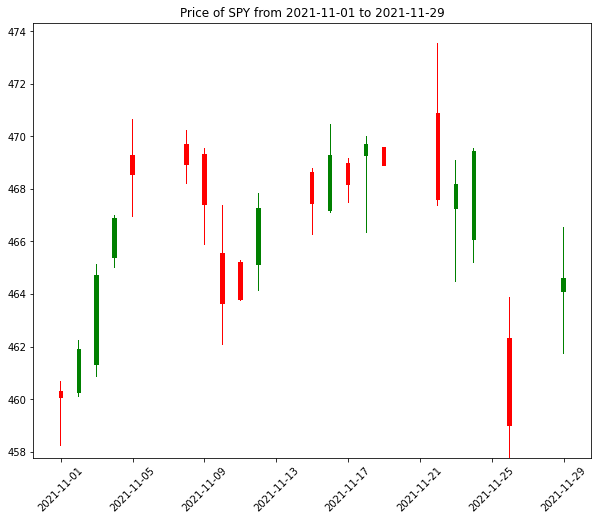

In [24]:
def plot_bars(bars, show_lines=False):
    plt.figure(figsize=(10,8))
    
    # pick the up (or green) bars
    up = bars.loc[bars['close'] >= bars['open']]
    # pick the down (or red) bars
    down = bars.loc[bars['close'] < bars['open']]
    
    # both up and down periods will have a thin bar between
    # the high and low, the "wick" of the candle
    plt.bar(up.index, up.high - up.low, bottom=up.low, color="green", width=0.05)
    plt.bar(down.index, down.high - down.low, bottom=down.low, color="red", width=0.05)
    
    # then, we plot the thicker candle part. 
    plt.bar(up.index, up.close - up.open, bottom=up.open, color="green", width=0.25)
    plt.bar(down.index, down.open - down.close, bottom=down.close, color="red", width=0.25)
    
    plt.xticks(rotation=45)
    plt.title(f'Price of SPY from {bars.index[0]:%Y-%m-%d} to {bars.index[-1]:%Y-%m-%d}')
  
    if show_lines:
        plt.plot(bars['high'], color='green', alpha=0.25, label='high')
        plt.plot(bars['low'], color='red', alpha=0.25, label='low')
        plt.plot(bars['open'], color='black', ls=':', alpha=0.25, label='open')
        plt.plot(bars['close'], color='black', ls='--', alpha=0.25, label='close')
        plt.legend()

plot_bars(spy_daily.iloc[-20:])

Now isn't that better? It takes a little practice to read quickly, but is much more informative at a glance.  If you show the high/low/open/close as lines, you can see how they correspond to the points on the candle (and how much clearer the bars are than the lines).

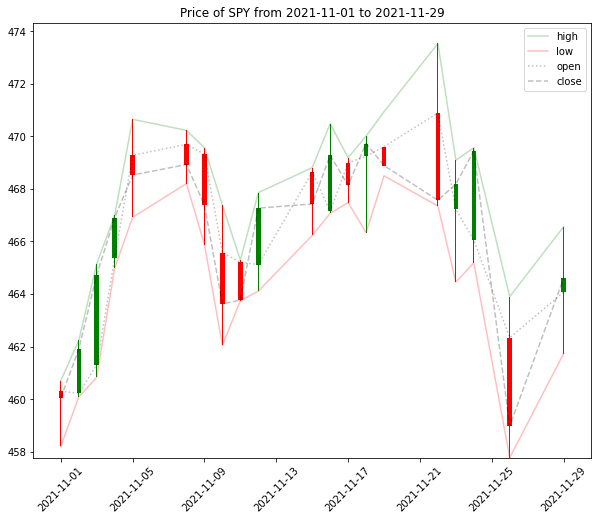

In [25]:
plot_bars(spy_daily.iloc[-20:], show_lines=True)

Just to be clear, if the close price is higher than the open, the bar will be green. If the close is lower than the open, it will be red. And the thinner part of the bar shows you the high and low prices for the day.

Now we have more than 20 years worth of SPY prices to look at, and each trading day has a single bar, just like the values above. As an exercise, you could look plot more data as bars.

## Seasonality
To keep things simple, we will only look at the idea of seasonality in this article, and we will only use the end of day price, the close. For now, we'll also ignore dividends and leap years.

First, let's talk about what seasonality is. The idea behind seasonality is that there is some sort of regular seasonal pattern than impacts stock prices. If there is a seasonality effect, we'd assume we could get a feel for that by looking at average returns for all the years and see if returns tend to look different at different parts of the year.

### Returns
The first thing we need to do is get returns for SPY. We do this because comparing prices across years doesn't make sense. We want to see the percentage moves in SPY instead, not the difference in prices. There are multiple ways to calculate returns, but an easy way to calculate percent returns in pandas is to use ```pct_change```.

In [26]:
spy_daily['daily_return'] = spy_daily['close'].pct_change()
spy_daily.head()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,daily_return
1999-11-01,136.500000,137.000000,135.562500,135.562500,90.318326,4006500,0.0,1.0,NaN
1999-11-02,135.968704,137.250000,134.593704,134.593704,89.672867,6516900,0.0,1.0,-0.007146
1999-11-03,136.000000,136.375000,135.125000,135.500000,90.276685,7222300,0.0,1.0,0.006734
1999-11-04,136.750000,137.359299,135.765594,136.531204,90.963724,7907500,0.0,1.0,0.007610
1999-11-05,138.625000,139.109299,136.781204,137.875000,91.859026,7431500,0.0,1.0,0.009842


You can see that the ```daily_return``` column has the percentage increase or decrease in price for each day. We can use the ```cumsum``` method to see what the total returns look like over time. 

<AxesSubplot:>

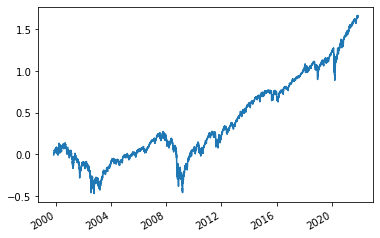

In [27]:
spy_daily['daily_return'].cumsum().plot()

Now that we have simple percent returns, we see that the chart starts at 0, then moves up to 150+% return. This mimics the price plot above, but we can now lay our years on top of each other. One way to do this is to just look at average return for each day of the year.

How would we go about doing this? First, we can get the day of the year from the dates in our index.

In [28]:
spy_daily.index.day_of_year

Int64Index([305, 306, 307, 308, 309, 312, 313, 314, 315, 316,
            ...
            319, 320, 321, 322, 323, 326, 327, 328, 330, 333],
           dtype='int64', length=5556)

The next step is to group our returns so day 1 of each year is together, day 2 of each year, and so on. This is what the ```DataFrame.groupby``` method does. It makes a group for each value passed into the function, and can apply aggregate functions to that group. We can get the mean daily return for that day of the year in our entire dataset by using ```mean``` and looking only at ```daily_return```.

In [29]:
spy_daily.groupby(spy_daily.index.day_of_year).mean()['daily_return']

2      0.006570
3      0.004355
4     -0.002164
5     -0.001901
6      0.000482
         ...   
362   -0.000548
363    0.001660
364   -0.002844
365   -0.000749
366    0.008551
Name: daily_return, Length: 365, dtype: float64

This just gives us a single series with each day of the year containing the mean. Note that the data starts at 2 because the stock markets are always closed on New Years Day. It has 366 days because of leap years (which I said I'd ignore earlier). Now we can plot the cumulative sum of the mean daily returns, and see what the averages look like.

<AxesSubplot:>

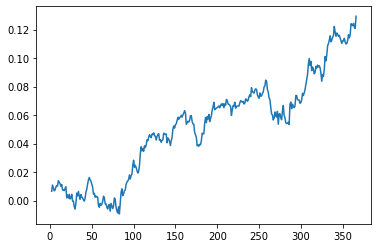

In [30]:
spy_daily.groupby(spy_daily.index.day_of_year).mean()['daily_return'].cumsum().plot()

Hmmm, that looks interesting. There seems to be poor returns in the beginning of the year, great returns in the spring, a bad dip in the fall, and a great end of the year.

Another interesting way to look at the data is to look at the monthly mean returns. We can do this easily with ```groupby``` again, but using a bar chart makes more sense. 

<AxesSubplot:>

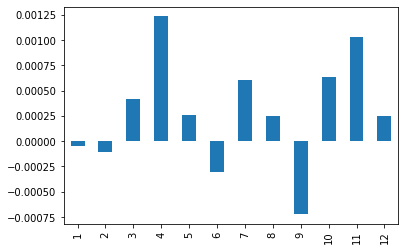

In [31]:
spy_daily.groupby(spy_daily.index.month).mean()['daily_return'].plot.bar()

Here it looks like September is a horrible month to be in the stock market, and April is great.

Now stock returns can have very big outliers, and those will definitely influence the results, so using the mean may not be the best idea. These outliers are also very hard (impossible?) to predict, most investors will not be unable to avoid the bad outliers and participate in the good ones. It might make more sense to see what the median returns look like.

<AxesSubplot:>

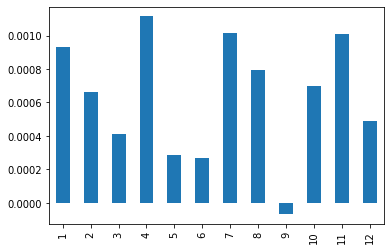

In [32]:
spy_daily.groupby(spy_daily.index.month).median()['daily_return'].plot.bar()

From the median returns, we can see that every month has positive median returns, except for September. It does look like *maybe* there is a bit of a seasonal effect, but not as clearly as when looking at the means.

## What does this mean?
Now we will not jump to any conclusions from this quick analysis, but there is an [often discussed seasonality to stock returns](https://en.wikipedia.org/wiki/Sell_in_May), with some saying that you should sell your stocks in May and wait until October to get back into the market. We can even see the idea that returns in May, June and September are not as strong as the rest of the year. But this is just on average, and there are still positive returns in the middle of the year (with July and August pretty high). If you sold your stocks and rebought them in October, you'd lose all those returns, plus you'd have to pay transaction costs to move in and out of the market.

Maybe we could look at each year's data and see if any years tend to stick out, so we can understand what the outliers might have been for those years? We can do this by iterating through the years, grabbing just the part of our ```DataFrame``` for that year using a boolean expression, and plotting the returns for that year. You can read more about [boolean indexing here](https://www.wrighters.io/boolean-indexing-in-pandas/).

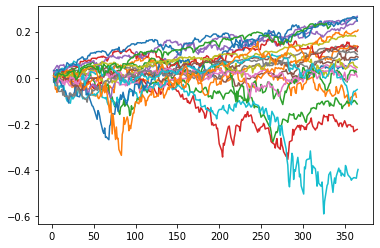

In [33]:
for year in spy_daily.index.year.unique():
    sub = spy_daily.loc[spy_daily.index.year == year]
    plt.plot(sub.index.day_of_year, sub['daily_return'].cumsum())

What sticks out to me are the years with very big drawdowns. There's fewer big spikes up. (This fits the old adage about stocks, it's an escalator up, but an elevator down). Let's find out which ones those are. If we make a simple function to find the value of lowest cumulative returns for a given year, we can see what the years are with those low points on the plot above.

In [34]:
def min_return(rets):
    # get the index of the minimum value, and the value itself
    return rets.loc[rets.idxmin()], rets.idxmin()

for year in spy_daily.index.year.unique():
    sub = spy_daily.loc[spy_daily.index.year == year]
    minimum, dt = min_return(sub['daily_return'].cumsum())
    print(f"{year} {minimum * 100:6.2f}% on {dt:%Y-%m-%d}")

1999  -0.71% on 1999-11-02
2000 -12.35% on 2000-12-20
2001 -28.00% on 2001-09-21
2002 -35.37% on 2002-10-09
2003  -8.74% on 2003-03-11
2004  -3.64% on 2004-08-06
2005  -5.85% on 2005-04-20
2006  -1.32% on 2006-06-13
2007  -2.93% on 2007-03-05
2008 -59.01% on 2008-11-20
2009 -26.86% on 2009-03-09
2010  -7.63% on 2010-07-02
2011 -11.63% on 2011-10-03
2012   1.59% on 2012-01-03
2013   2.22% on 2013-01-08
2014  -5.77% on 2014-02-03
2015  -8.72% on 2015-08-25
2016 -10.61% on 2016-02-11
2017   0.77% on 2017-01-03
2018 -11.66% on 2018-12-24
2019  -2.28% on 2019-01-03
2020 -33.64% on 2020-03-23
2021  -1.36% on 2021-01-04


OK, we can see that 2001 and 2002 (tech bubble), and 2008, 2009 (great financial crisis), and 2020 (Covid) all stick out here. Let's just see what those look like on their own.

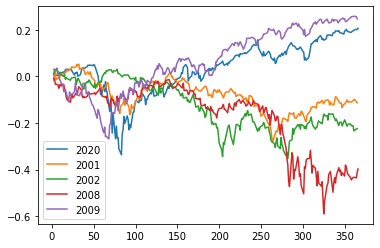

In [35]:
for year in [2020, 2001, 2002, 2008, 2009]:
    sub = spy_daily[f"{year}":f"{year}"]
    plt.plot(sub.index.day_of_year, sub['daily_return'].cumsum(), label=year)
plt.legend()

So we could remove the big outlier years of 2008, 2009, and 2020 from our earlier results just to see what the "normal" seasonality is, especially in the beginning and end of the calendar year.  Note that this is not a good idea to do when building trading models, but right now we're just trying to explore and understand the data. I do this in pandas by using another boolean expression, but use the inverse operator ```~``` and ```isin``` to deselect all values from those years.

<AxesSubplot:>

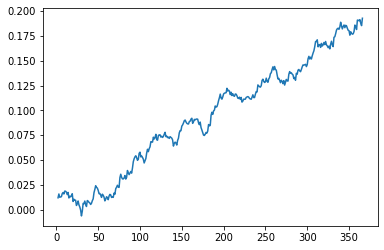

In [36]:
spy_daily_red = spy_daily.loc[~spy_daily.index.year.isin([2001, 2002, 2008, 2019, 2020])]
spy_daily_red.groupby(spy_daily_red.index.day_of_year).mean()['daily_return'].cumsum().plot()

Now this a bit more smooth. Notice that the returns just sort of move up and to the right, without any longer trends up or down? With this information, the idea that there's persistent multi month seasonality doesn't seem to hold up as well as before.

What about looking at the monthly results with this reduced data set?

<AxesSubplot:>

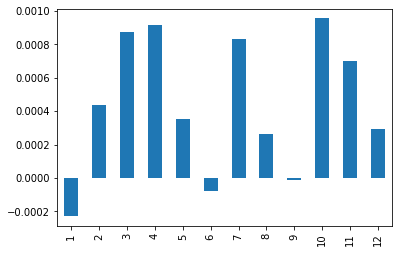

In [37]:
spy_daily_red.groupby(spy_daily_red.index.month).mean()['daily_return'].plot.bar()

The interesting thing here is that September and June are still not a profitable on average, even with the worst years removed.  

## What could we go from here?
We are not going to draw definitive conclusions from this brief exploration to inform decisions about investing or trading, but this initial investigation could send things in some interesting directions. Maybe some questions came up for you when reading this and you want think about other information you could explore.

### More data
If you can get more historical data, that would be valuable. In our free data set, we are only able to go back 20 years, but with more historical data we might be able to see more consistent months that display seasonality. Maybe the effect used to be stronger in the past and we could compare different decades. While we can do some of this with our current data, we would be more confident with more data.

Another option is to get more granular data, maybe on 1 minute or 1 hour increments. This would allow us to look at intraday seasonality, are there times of day when the market tends to move up more than others?  Or with our current data, maybe seasonality is visible on a monthly basis? There can be many monthly events that influence the market, such as releases of important data or paychecks being deposited in bank accounts at the beginning and end of the month. On an annual basis, the payment of taxes and distribution of tax refunds can influence the market. In future articles, I'll look at some of these ideas.